This notebook fits a hierarchical GLM-HMM. The model includes observed discrete states $z_t \in \{1,...,N \}$, unobserved hidden states $w_t \in \{1,...,M\}$, and external inputs $u_t \in \mathbb{R}^U$. The external inputs modify the transition probabilities between the observed states according to a GLM, where the weights of the GLM depend on the hidden states. Formally, the states as generated by the following model:

$$ w_t \mid w_{t-1} \sim \text{Categorical}(\pi_{w_{t-1}}) $$

$$ z_t \mid z_{t-1}, w_t, u_t \sim \text{Categorical}(\exp(B_{w_t} u_t)+P_{z_{t-1}}) $$

where $\pi$ is the transition matrix between hidden states, $\mathbf{B}_i \in \mathbb{R}^{N \times U}, i=1,...,M$ are GLM weight matrices, and $P \in \mathbb{R}^{N \times N}$ is the baseline transition matrix between observed states. The parameters are generated by the following prior distributions:

$$ \pi \sim \text{sticky-HDP}(\gamma, \alpha, \kappa) $$

$$ B_{i,j} \sim \text{Normal}(0, \sigma_B^2)$$

$$ P_{i,j} \sim \text{Normal}(0, \sigma_P^2)$$

In [238]:
import tqdm
import jax
import jax.numpy as jnp
import jax.random as jr
import blackjax

from jax_moseq.utils.distributions import sample_hmm_stateseq
from jax_moseq.utils.transitions import resample_hdp_transitions, init_hdp_transitions
from jax_moseq.utils import pad_along_axis
from functools import partial
na = jnp.newaxis

@partial(jax.jit, static_argnames=('num_steps',))
def resample_glm_params(seed, z, u, w, mask, P, B, sigmasq_P, sigmasq_B, 
                        step_size=1e-3, num_steps=10, **kwargs):
    """
    Resamples the GLM weights and baseline transition matrix using HMC.

    Parameters
    ----------
    seed : jr.PRNGKey
        JAX random seed.
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    w : jnp.ndarray of shape (num_seqs, T)
        Hidden states.
    mask : jnp.ndarray of shape (num_seqs, T)
        Mask for observed data.
    P : jnp.ndarray of shape (N, N)
        Initial baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (M, N, U)
        Initial GLM weights for each hidden state.
    sigmasq_P : float
        Prior variance for each element of the baseline transition matrix.
    sigmasq_B : float
        Prior variance for each element of the GLM weights.
    step_size : float
        HMC step size.
    num_steps : int
        Number of HMC integration steps.

    Returns
    ------
    P : jnp.ndarray of shape (N, N)
        Updated baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (M, N, U)
        Updated GLM weights for each hidden state.
    """

    def logprob_fn(args):
        P,B = args
        log_likelihood = (glm_log_likelihood(z, u, P, B[w]) * mask).sum()
        log_prior = -0.5 * (P**2 / sigmasq_P + B**2 / sigmasq_B).sum()
        return log_likelihood + log_prior

    inv_mass_matrix = jnp.ones(P.size + B.size)
    hmc = blackjax.hmc(logprob_fn, step_size, inv_mass_matrix, num_steps)
    state, info = hmc.step(seed, hmc.init((P, B)))
    P,B = state.position
    return P,B


def glm_log_likelihood(z, u, P, B):
    """
    Computes the log-likelihood of each observed transition under the GLM.

    Parameters
    ----------
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    P : jnp.ndarray of shape (N, N)
        Baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (N, U)
        GLM weights.

    Returns
    -------
    log_likelihoods : jnp.ndarray of shape (num_seqs, T)
        Log-likelihoods under the GLM.
    """
    baseline = pad_along_axis(P[z[...,:-1]], (1,0), axis=-2, value=0)
    bias = (B @ u[...,na]).squeeze(-1)
    normalizer = jax.nn.logsumexp(baseline + bias, axis=-1)
    log_likelihoods = jnp.take_along_axis(baseline + bias, z[...,na], axis=-1).squeeze(-1) - normalizer
    return log_likelihoods
    

@jax.jit
def resample_discrete_stateseqs(seed, z, u, mask, pi, P, B, **kwargs):
    """
    Resamples the discrete state sequence ``w``.

    Parameters
    ----------
    seed : jr.PRNGKey
        JAX random seed.
    z : jnp.ndarray of shape (num_seqs, T)
        Observed discrete states.
    u : jnp.ndarray of shape (num_seqs, T, U)
        Observed external inputs.
    mask : jnp.ndarray of shape (num_seqs, T)
        Mask for observed data.
    pi : jnp.ndarray of shape (M, M)
        Hidden state transition matrix.
    P : jnp.ndarray of shape (N, N)
        Baseline transition matrix for the observed states.
    B : jnp.ndarray of shape (M, N, U)
        GLM weights for each hidden state.

    Returns
    ------
    w : jax_array of shape (num_seqs, T)
        Discrete state sequences.
    """
    num_seqs = mask.shape[0]
    log_likelihoods = jax.lax.map(partial(glm_log_likelihood, z, u, P), B)
    _, w = jax.vmap(sample_hmm_stateseq, in_axes=(0,na,0,0))(
        jr.split(seed, num_seqs),
        pi,
        jnp.moveaxis(log_likelihoods,0,-1),
        mask.astype(float))
    return w


def resample_model(data, seed, states, params, hypparams, states_only=False, **kwargs):
    """
    Resample the GLM-HMM model. 

    Below, `T` is the number of time steps, `M` is the number of hidden states,
    `N` is the number of observed states, and `U` is the number of external inputs.

    Parameters
    ----------
    data : dict
        Data dictionary containing
        - `z` : jnp.ndarray of shape (num_seqs, T)
            Observed discrete states.
        - `u` : jnp.ndarray of shape (num_seqs, T, U)
            Observed external inputs.
        - `mask` : jnp.ndarray of shape (num_seqs, T)
            Mask for observed data.

    seed : jr.PRNGKey
        JAX random seed.

    states : dict
        State dictionary containing
        - `w` : jnp.ndarray of shape (num_seqs, T)
            Hidden states.

    params : dict
        Parameter dictionary containing
        - `pi` : jnp.ndarray of shape (M, M)
            Hidden state transition matrix.
        - `betas` : jnp.ndarray of shape (M,)
            Global concentration weights for the HDP prior over hidden state transitions.
        - `P` : jnp.ndarray of shape (N, N)
            Baseline transition matrix for the observed states.
        - `B` : jnp.ndarray of shape (M, N, U)
            GLM weights for each hidden state.
            
    hypparams : dict
        Dictionary with two groups of hyperparameters:
        - trans_hypparams : dict
            HDP transition hyperparameters (see 
            `jax_moseq.models.glm_hmm.initialize.init_glm_params`)
        - glm_hypparams : dict
            GLM hyperparameters (see `jax_moseq.utils.transitions.init_hdp_transitions`)

    states_only : bool, default=False
        Only resample states if True.

    Returns
    ------
    model : dict
        Dictionary containing the hyperparameters and
        updated seed, states, and parameters of the model.
    """
    seed = jr.split(seed)[1]

    if not states_only: 
        params['betas'], params['pi'] = resample_hdp_transitions(
            seed, **data, **states, **params,
            **hypparams['trans_hypparams'])
        
        params['P'], params['B']= resample_glm_params(
            seed, **data, **states, **params, 
            **hypparams['glm_hypparams'])

    states['w'] = resample_discrete_stateseqs(
        seed, **data, **states, **params)

    return {'seed': seed,
            'states': states, 
            'params': params, 
            'hypparams': hypparams}


######################################################################

def init_glm_params(seed, sigmasq_B, sigmasq_P, input_dim, 
                    num_observed_states, num_states, **kwargs):
    """
    Initialize GLM weights `B` and baseline transition matrix `P` form their priors.
    """
    P = jr.normal(seed, (num_observed_states, num_observed_states)) * sigmasq_P**0.5
    B = jr.normal(seed, (num_states, num_observed_states, input_dim)) * sigmasq_B**0.5
    return P, B


def init_params(seed, trans_hypparams, glm_hypparams, **kwargs):
    """
    Initialize the parameters of the GLM-HMM model.
    """
    params = {}
    params['betas'], params['pi'] = init_hdp_transitions(seed, **trans_hypparams)
    params['P'], params['B'] = init_glm_params(seed, **glm_hypparams, **trans_hypparams)
    return params
 

def init_model(data=None,
               states=None,
               params=None,
               hypparams=None,
               seed=jr.PRNGKey(0),
               verbose=False,
               **kwargs):
    """
    Initialize the GLM-HMM model.

    Below, `T` is the number of time steps, `M` is the number of hidden states,
    `N` is the number of observed states, and `U` is the number of external inputs.

    Parameters
    ----------
    data : dict
        Data dictionary containing
        - `z` : jnp.ndarray of shape (num_seqs, T)
            Observed discrete states.
        - `u` : jnp.ndarray of shape (num_seqs, T, U)
            Observed external inputs.
        - `mask` : jnp.ndarray of shape (num_seqs, T)
            Mask for observed data.

    hypparams : dict
        Dictionary with two groups of hyperparameters:
        - trans_hypparams : dict
            HDP transition hyperparameters, including `alpha`, `gamma`, `kappa`,
            and `num_states` (see `jax_moseq.utils.transitions.init_hdp_transitions`)
        - glm_hypparams : dict
            GLM hyperparameters, including `sigmasq_P`, `sigmasq_B`,
            `num_steps`, `step_size`, `input_dim` and `num_observed_states`
            (see `jax_moseq.models.glm_hmm.initialize.init_glm_params`, and
             `jax_moseq.models.glm_hmm.initialize.resample_glm_params`) 

    states : dict, optional
        Initial values for the states, as a dictionary containing:
        - `w` : jnp.ndarray of shape (num_seqs, T)
            Hidden states.

    params : dict, optional
        Initial values for the parameters, as a dictionary containing:
        - `pi` : jnp.ndarray of shape (M, M)
            Hidden state transition matrix.
        - `betas` : jnp.ndarray of shape (M,)
            Global concentration weights for the HDP prior over hidden state transitions.
        - `P` : jnp.ndarray of shape (N, N)
            Baseline transition matrix for the observed states.
        - `B` : jnp.ndarray of shape (M, N, U)
            GLM weights for each hidden state.

    seed : int or jr.PRNGKey, default=jr.PRNGKey(0)
        Initial JAX random seed.

    verbose : bool, default=False
        Whether to print progress info during initialization.

    Returns
    -------
    model : dict
        Dictionary containing the hyperparameters and
        initial seed, states, and parameters of the model.
        
    Raises
    ------
    ValueError
        If the subset of the parameters provided by the caller
        is insufficient for model initialization.
    """
    #_check_init_args(data, states, params, hypparams)
    
    model = {}

    model['hypparams'] = hypparams
        
    if isinstance(seed, int):
        seed = jr.PRNGKey(seed)
    model['seed'] = seed
    
    if params is None:
        if verbose:
            print('GLM-HMM: Initializing parameters')
        params = init_params(seed, **hypparams)
    else:
        params = jax.device_put(params)
    model['params'] = params

    if states is None:
        if verbose:
            print('GLM-HMM: Initializing states')
        states = {'w': resample_discrete_stateseqs(
            seed, **jax.device_put(data), **params)}
    else:
        states = jax.device_put(states)
    model['states'] = states

    return model


In [240]:
data = {'z':jnp.array(z)[na], 'mask':jnp.ones_like(z)[na], 'u':jnp.array(u)[na]}

hypparams = {
    'trans_hypparams': {
        'alpha':5, 
        'gamma':1000, 
        'kappa':100000, 
        'num_states':M
    },
    'glm_hypparams': {
        'sigmasq_B':1, 
        'sigmasq_P':1, 
        'step_size':1e-3, 
        'num_steps':10, 
        'input_dim':U, 
        'num_observed_states':N
    }
}

z,u,w,mask = jnp.array(z),jnp.array(u),jnp.array(w),jnp.array(jnp.ones_like(z))
P,B = jnp.array(P),jnp.array(B)

model = init_model(data=data, hypparams=hypparams)
for i in tqdm.trange(100): model = resample_model(data, **model)


100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


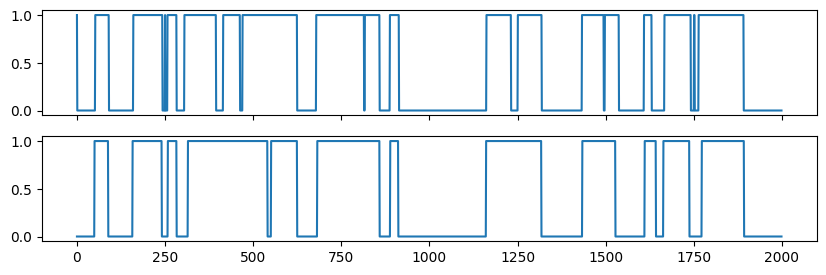

In [243]:
fig,axs = plt.subplots(2,1, sharex=True)
axs[0].plot(model['states']['w'].squeeze()[:2000])
axs[1].plot(w[:2000])
fig.set_size_inches((10,3))

In [158]:
model['params']['P']

DeviceArray([[-0.3721109 ,  0.26423115, -0.18252768],
             [-0.7368197 ,  0.44973662, -0.1521442 ],
             [-0.67135346, -0.5908641 ,  0.73168886]], dtype=float32)

In [159]:
model['params']['B']

DeviceArray([[[ 0.18784384],
              [-1.2833426 ],
              [ 0.6494181 ]],

             [[ 1.2490594 ],
              [ 0.24447003],
              [-0.11744965]]], dtype=float32)

In this toy example, we will simulate a simple scenario involving a robot in a 1D environment responding to a moving object $u$. The robot has 3 observable positions (left, middle, right), and two hidden states (attract and repel). The robot either moves toward or away from $u$ depending on the hidden state. Here we will simulate the case where $u$ oscillates sinusoidally. The model parameters are as follows:

- Number of observed states (positions): $N = 3$
- Number of hidden states (modes): $M = 2$
- External input dimension: $U = 1$
- Transition probabilities between the hidden states:

$$\pi = \begin{bmatrix} 0.99 & 0.01 \\ 0.01 & 0.99 \end{bmatrix}$$

- GLM weights and the baseline transition matrix:

$$B_\text{attract} = \begin{bmatrix} 1 \\ 0 \\ -1 \end{bmatrix}, \ \ \ 
  B_\text{repel} = \begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix}, \ \ \
  P = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$$


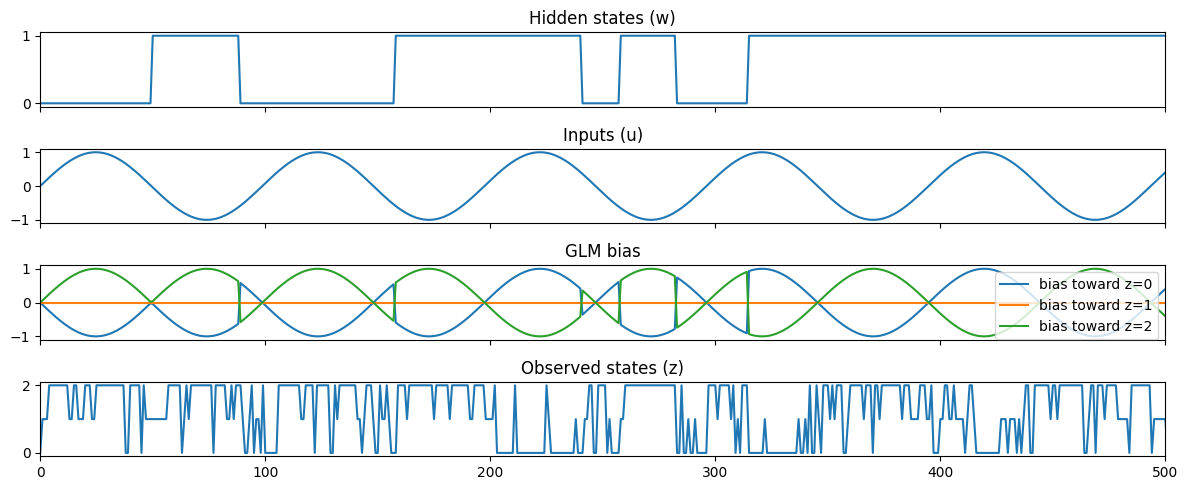

In [179]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(43)

N = 3  # number of observed states
M = 2  # number of hidden states
U = 1  # external input dimension
T = 50000  # number of time steps

# Transition probabilities between hidden states
pi = np.array([[0.99, 0.01],
               [0.01, 0.99]])

# GLM weight matrices
B1 = np.array([[-1], [0], [1]])
B2 = np.array([[1], [0], [-1]])
B = np.stack([B1, B2], axis=0).astype(float)

# Baseline transition matrix between observed states
P = np.eye(3)

# External input
u = np.sin(np.arange(T)/np.pi/5)[:,na]

# Simulate hidden states
w = np.zeros(T, dtype=int)
for t in range(1, T):
    w[t] = np.random.choice(M, p=pi[w[t-1]])

# Simulate observed states
z = np.zeros(T, dtype=int)
for t in range(1, T):
    transition_prob = np.exp(B[w[t]] @ u[t] + P[z[t-1]])
    transition_prob /= transition_prob.sum()
    z[t] = np.random.choice(N, p=transition_prob)

# Plot results
fig,axs = plt.subplots(4,1,figsize=(12, 5), sharex=True)
axs[0].plot(w)
axs[1].plot(u)

glm_bias = (B[w]@(u[:,:,na])).squeeze(-1)
for i in range(N):
    axs[2].plot(glm_bias[:,i], label=f"bias toward z={i}")
axs[2].legend(loc='upper right')
axs[3].plot(z)

axs[0].set_title("Hidden states (w)")
axs[1].set_title("Inputs (u)")
axs[2].set_title("GLM bias")
axs[3].set_title("Observed states (z)")
axs[3].set_xlim([0,500])
plt.tight_layout()